In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

┌ Warning: backend `GR` is not installed.
└ @ Plots C:\Users\zachl\.julia\packages\Plots\HyyIK\src\backends.jl:43


StateSpaceDynamics

In [30]:
 # Create Guassian Emission Models
 output_dim = 2
 μ = [-5.0, -4.0]
 Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
 emission_1 = GaussianEmission(output_dim=output_dim, μ=μ, Σ=Σ)

 μ = [2.0, 1.0]
 Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
 emission_2 = GaussianEmission(output_dim=output_dim, μ=μ, Σ=Σ)

 # Create GaussianHMM
 true_model = GaussianHMM(K=2, output_dim=2)
 true_model.B[1] = emission_1
 true_model.B[2] = emission_2
 true_model.A = [0.9 0.1; 0.8 0.2]

 # Generate trialized synthetic data
 n = 100
 num_trials = 30
 Y = Vector{Matrix{Float64}}(undef, num_trials)
 trial_labels = Vector{Vector{Int}}(undef, num_trials)  

 for i in 1:num_trials
     true_labels, data = StateSpaceDynamics.sample(true_model, n=n)  # Generate data and labels
     Y[i] = data  # Store data matrix for the ith trial
 end

 # Fit a model to the trialized synthetic data
 est_model = StateSpaceDynamics.GaussianHMM(K=2, output_dim=2)
 lls = StateSpaceDynamics.fit!(est_model, Y, max_iters=100)

 # Test that model output is correct
 # @test StateSpaceDynamics.loglikelihood(est_model, Y) >= StateSpaceDynamics.loglikelihood(true_model, Y)
#  @test isapprox(est_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(est_model.B[1].μ, true_model.B[2].μ, atol=0.1)
#  @test isapprox(est_model.B[1].Σ, true_model.B[1].Σ, atol=0.1) || isapprox(est_model.B[1].Σ, true_model.B[2].Σ, atol=0.1)
#  @test isapprox(est_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(est_model.B[2].μ, true_model.B[1].μ, atol=0.1)
#  @test isapprox(est_model.B[2].Σ, true_model.B[2].Σ, atol=0.1) || isapprox(est_model.B[2].Σ, true_model.B[1].Σ, atol=0.1)

Using new GLM function


12-element Vector{Float64}:
    -Inf
 -61661.07886744215
  -7970.205243731608
  -7969.9889432338205
  -7966.313780429003
  -7908.910935246873
  -7382.955212009898
  -4524.574617256984
  -3219.5372236465937
  -2940.9685061678965
  -2614.23152751682
  -2614.2315272412857

# Gaussian HMM

In [2]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=20000
true_labels, data = SSD.sample(true_model, n=n)

# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(test_model, data)

print(isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
print(isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

truetrue

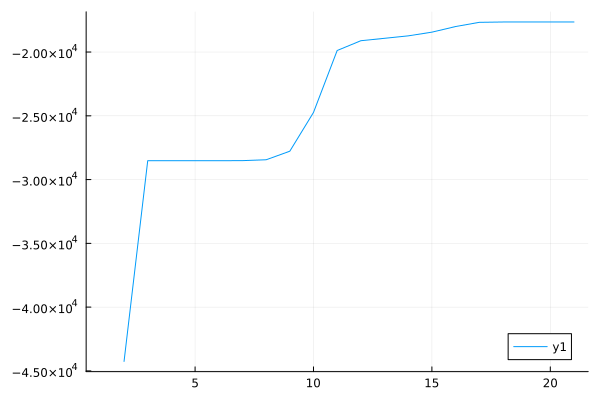

In [3]:
plot(ll)

In [14]:
ll_diff = diff(ll)
any(ll_diff .< 0) == false

true

# Switching Gaussian Regression #

In [13]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
ll = SSD.fit!(test_model, data, Φ)

# Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))

truetrue

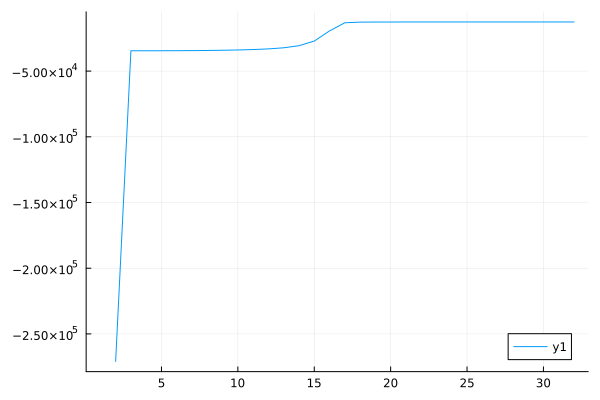

In [14]:
plot(ll)

# Switching Bernoulli Regression #

In [3]:
"""
Create Bernoulli Regression Model
"""
# Make Emission Models
emission_1 = SSD.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([3, 1, 8], :, 1))
emission_2 = SSD.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-4, -5, 0.1], :, 1))

# Create Switching Bernoulli Regression and add the emissions
true_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n=20000
Φ = randn(n, 2)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Fit a new Bernoulli Regression Model to the data
test_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
ll = SSD.fit!(test_model, data, Φ, max_iters=200)

# # Test it works alright
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))

truetrue

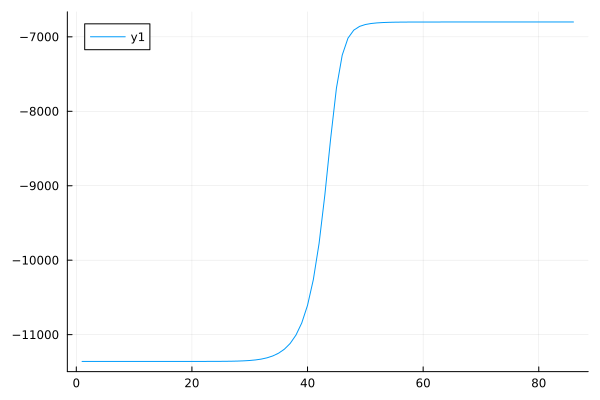

In [4]:
plot(ll[3:end])

# Switching Poisson Regression

In [5]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1))

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([2.0, 1.0, 4.0, 2.0], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1))
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=200)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))


truetrue

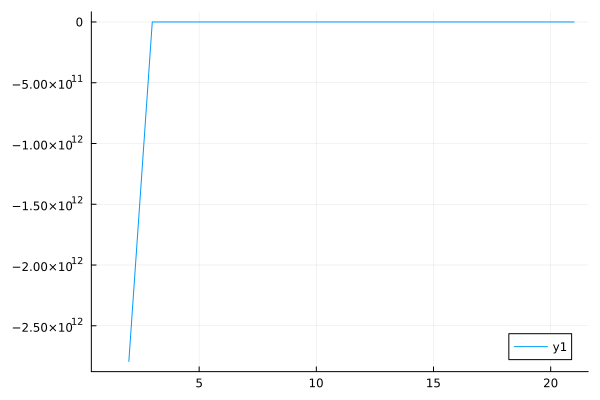

In [13]:
plot(ll)